MSIN0097: Predictive Analytics - Individual Coursework
=====================
---------------------------------------
Predicting Sneaker Resale Price Premiums
=====================
Github Repository: https://github.com/sidnand24/MSIN0097-Assignment   
Word Count: 1933                                                                                                                     
March 2022

<h3>Table of Contents</h3>

* [1. Introduction](#1.-Introduction)
* [2. Dataset](#2.-Dataset)
* [3. Data Cleaning & Preparation](#3.-Data-Cleaning-&-Preparation)
    * [3.1 Feature Engineering](#3.1-Feature-Engineering)
    * [3.2 Supplementary Data](#3.2-Supplementary-Data)
* [4. Explanatory Data Analysis](#4.-Explanatory-Data-Analysis)
* [5. ML Models](#5.-ML-Models)
    * [5.1 Linear Regression](#5.1-Linear-Regression)
    * [5.2 Elastic Net](#5.2-Elastic-Net)
    * [5.3 Linear Support Vector Machine Regressor](#5.3-Linear-Support-Vector-Machine-Regressor)
    * [5.4 Decision Tree](#5.4-Decision-Tree)
    * [5.5 Random Forest](#5.5-Random-Forest)
    * [5.6 XGboost](#5.6-XGboost)
    * [5.7 Voting Regressor](#5.7-Voting-Regressor)
* [6. Conclusion](#6.-Conclusion)
* [References](#References)

 

# 1. Introduction


The once niche market of sneaker reselling has exploded in recent years and has become a lucrative side-hustle for many aspiring entrepreneurs. Moreover, the analysis by Cowen Inc. estimates the market to reach $30 billion globally by 2030 (Kernan et al., 2020). Some sneakers have an extremely high demand coupled with a limited supply. This paradox for potential buyers ensures that those that are successful in securing the shoe can either add a limited shoe to their collection or benefit from increased resale prices.

Online sneaker marketplaces such as GOAT or StockX provide a platform for users to connect with resellers of their desired sneakers. StockX operates similarly to a stock exchange. Resellers can list their shoes for whatever price they desire, and users make bids or offers to ensure a deal can be agreed.

This report will seek to investigate whether machine learning models can help predict return on investment for highly desired sneakers. This can enable buyers to identify potentially undervalued sneakers to invest in and resell.

#### Initial Setup

In [70]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import Image
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# importing models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import VotingRegressor

In [2]:
# # run this code cell to import relevant additional packages
# !pip install xgboost
# !pip install -U kaleido

In [3]:
# reading the data directly from the StockX Data Challenge 2019 website
url = "https://s3.amazonaws.com/stockx-sneaker-analysis/wp-content/uploads/2019/02/StockX-Data-Contest-2019-3.xlsx"
my_file = requests.get(url)
data_file = open('StockX_data.xlsx', 'wb')
data_file.write(my_file.content)
data_file.close()

df = pd.read_excel("StockX_data.xlsx", sheet_name = 1)
pd.set_option('display.max_columns', None) # To view all columns

## 2. Dataset

This report will investigate sneaker sale data from StockX. The data, created as part of the website's 2019 Data Contest, consists of a random sample of Off-White and Yeezy transactions within the United States (US) between September 2017 and February 2019. The data can be found under the following link: https://stockx.com/news/the-2019-data-contest/.

Both Off-Whites and Yeezys are some of the most coveted sneakers on the market. The Off-White sneakers were produced as part of the collaboration between Nike and the late luxury designer Virgil Abloh. This dataset focuses on a selection of Off-White sneakers that were part of 'The Ten' collection. On the other hand, the Yeezy line is a collaboration between Adidas and musician Kanye West and this dataset focuses on the Yeezy Boost 350 models.

#### Preliminary View

In [4]:
# first look at dataset
df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097.0,220,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685.0,220,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690.0,220,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075.0,220,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828.0,220,2017-02-11,11.0,Rhode Island


In [5]:
df.shape

(99956, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order Date    99956 non-null  datetime64[ns]
 1   Brand         99956 non-null  object        
 2   Sneaker Name  99956 non-null  object        
 3   Sale Price    99956 non-null  float64       
 4   Retail Price  99956 non-null  int64         
 5   Release Date  99956 non-null  datetime64[ns]
 6   Shoe Size     99956 non-null  float64       
 7   Buyer Region  99956 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 6.1+ MB


In [7]:
df.describe()

,Sale Price,Retail Price,Shoe Size
count,99956.000000,99956.00000,99956.000000
mean,446.634754,208.61359,9.344181
std,255.982918,25.20001,2.329588
min,186.000000,130.00000,3.500000
25%,275.000000,220.00000,8.000000
50%,370.000000,220.00000,9.500000
75%,540.000000,220.00000,11.000000
max,4050.000000,250.00000,17.000000


In [8]:
df.isna().sum()

Order Date      0
Brand           0
Sneaker Name    0
Sale Price      0
Retail Price    0
Release Date    0
Shoe Size       0
Buyer Region    0
dtype: int64

An initial view of the StockX data highlights a relatively clean dataset with no missing values. Further, with only 8 columns, additional feature engineering will be undertaken to prepare the data for the modelling stage.

## 3. Data Cleaning & Preparation

In [9]:
# clean column names for ease of reference
df.columns = map(str.lower, df.columns)
df.columns = df.columns.str.replace(' ','_')

In [10]:
# removing white space in front of Yeezy text and ensure text is lowercase
df["brand"] = df.brand.apply(lambda x: x.strip())

for variable in ['brand', 'sneaker_name', 'buyer_region']:
    df[variable] = df[variable].str.lower()

In [11]:
# investigating retail price
print('mean retail price: %.2f' % df.retail_price.mean())
print('median retail price: %.2f' % df.retail_price.median())
print('standard deviation retail price: %.2f' % df.retail_price.std())

mean retail price: 208.61
median retail price: 220.00
standard deviation retail price: 25.20


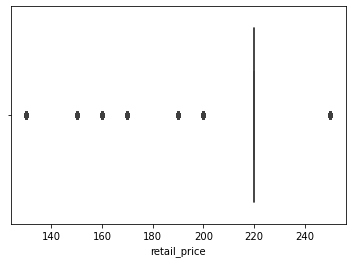

In [12]:
sns.boxplot(x = "retail_price", data= df);

In [13]:
# investigating sale price
print('mean sale price: %.2f' % df.sale_price.mean())
print('median sale price: %.2f' % df.sale_price.median())
print('standard deviation sale price: %.2f' % df.sale_price.std())

mean sale price: 446.63
median sale price: 370.00
standard deviation sale price: 255.98


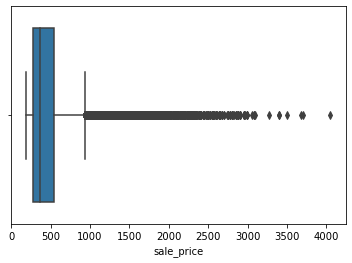

In [14]:
sns.boxplot(x = "sale_price", data= df);

Taking a closer look at the sale price variable, it is evident that there are a lot of outliers which are 1.5 times the interquartile range. This contrasts with the retail price variable which contains very little variability. This is due to the companies setting a consistent price per shoe type regardless of size for example. Nevertheless, these perceived sale price outliers are not dropped as they are not due to erroneous data, they are likely natural outliers. Very large sale prices are seen within the sneaker market as a result of the high demand and very sparse supply.

In [15]:
df.brand.value_counts()

yeezy        72162
off-white    27794
Name: brand, dtype: int64

Identifying the distribution of each shoe brand in the dataset there is a considerably larger amount of Yeezy sales. This indicates the popularity of the shoe. Stratified sampling will not be undertaken as Off-White sneakers still account for around 1/3 of the dataset with over 25,000 observations.

### 3.1 Feature Engineering

StockX obtain their revenue through fees charged to users. For every sale on the marketplace there is a 3% payment processing fee as well as a regressive transaction fee that is based on the final price sold. Sellers with a greater number of sales benefit from a lower transaction fee. As the maximum transaction fee charged to users is 10%, a new variable for sale price after 13% commission was created (10% plus the 3% payment processing fee).

In [16]:
df['sale_price_com'] = df.sale_price * 0.87

The return on investment (ROI) for sellers was then calculated using the sale price after commission to determine the price premium experienced on each sneaker. This variable will be the target variable for the modelling stage as it can account for differing retail prices amongst the sneakers.

In [17]:
def roi(x, y):
    final_profit = (x * 0.87) - y
    roi = (final_profit / y) * 100
    return round(roi, 2)

df['ROI'] = df.apply(lambda x: roi(x['sale_price'], x['retail_price']), axis = 1)

Focusing on the time specific variables, a new variable to determine the amount of time since the release date the sale occurred was created. As the number of days increases it may become increasingly harder to purchase certain sneakers due to their limited supply as there are no more retail sales. However, there is the potential that the sneaker may decrease in hype and therefore value after a certain amount of time has passed. In addition, variables outlining the week and month the sale took place were extracted.

In [18]:
df['day_diff'] = (df['order_date'] - df['release_date']).dt.days.astype('float64')

In [19]:
df['month'] = df['order_date'].dt.month

df['week'] = df['order_date'].apply(lambda x : x.strftime("%-V"))
df['week'] = df['week'].astype(int)

Size is a categorical variable, therefore, to include it within the model without encoding, the proportion of how often the size shows up within the dataset was calculated. More common shoe sizes may result in higher price premiums.

In [20]:
df['size_freq'] = df['shoe_size'].map(df['shoe_size'].value_counts(normalize = True))

In [21]:
# Create a new column with 1 if brand is Off-White 0 if Yeezy
df["off_white"] = df["brand"].apply(lambda x : 1 if 'off-white' in x else 0)

As the number of unique sneakers within the dataset was quite high (50), a new column with a refined style for each sneaker was created. This column groups together all the shoes with the same silhouette but differing colourways.

In [22]:
df.sneaker_name.nunique()

50

In [23]:
# erroneous entry as Yeezy boost 350 v2 dont include low in name
df['sneaker_name'] = df['sneaker_name'].replace('adidas-yeezy-boost-350-low-v2-beluga', 'adidas-yeezy-boost-350-v2-beluga')

In [24]:
def shoe_design(x):
    if '350-low' in x:
        return 'yeezy_low'
    if '350-v2' in x:
        return 'yeezy_v2'
    if 'jordan' in x.split("-"):
        return 'jordan'
    if 'air-force-1' in x:
        return 'airforce'
    if '90' in x.split("-"):
        return 'airmax90'
    if '97' in x.split("-"):
        return 'airmax97'
    if 'presto' in x.split("-"):
        return 'presto'
    if 'vapormax' in x.split("-"):
        return 'vapormax'
    if 'blazer' in x.split("-"):
        return 'blazer'
    if 'zoom' in x.split("-"):
        return 'zoom'
    else:
        return 'react'

df['design'] = df.apply(lambda x: shoe_design(x['sneaker_name']), axis=1)

The buyer region variable was also modified. States outside the top 5 for sneaker sales in the dataset were grouped together as 'other state'. The majority of shoe sales were attributed to transactions to those in California and New York. This cleaning step ensures fewer variables for the model to learn from and avoids specifying locations with a limited number of sales.

In [25]:
df.buyer_region.value_counts().to_frame().head(5)

,buyer_region
california,19349
new york,16525
oregon,7681
florida,6376
texas,5876


In [26]:
df['region'] = df.buyer_region
top5 = ["california", "new york", "oregon", "florida", "texas"]
df.region = df.region.apply(lambda x: x if x in top5 else 'other state')

In [27]:
# calculating the number of sales of each sneaker design
df['sneaker_count'] = df.groupby('design')['design'].transform('count')
df.sneaker_count = df.sneaker_count.astype(float)

In [28]:
df.head()

,order_date,brand,sneaker_name,sale_price,retail_price,release_date,shoe_size,buyer_region,sale_price_com,ROI,day_diff,month,week,size_freq,off_white,design,region,sneaker_count
0,2017-09-01,yeezy,adidas-yeezy-boost-350-v2-beluga,1097.0,220,2016-09-24,11.0,california,954.39,333.81,342.0,9,35,0.092551,0,yeezy_v2,california,71707.0
1,2017-09-01,yeezy,adidas-yeezy-boost-350-v2-core-black-copper,685.0,220,2016-11-23,11.0,california,595.95,170.89,282.0,9,35,0.092551,0,yeezy_v2,california,71707.0
2,2017-09-01,yeezy,adidas-yeezy-boost-350-v2-core-black-green,690.0,220,2016-11-23,11.0,california,600.30,172.86,282.0,9,35,0.092551,0,yeezy_v2,california,71707.0
3,2017-09-01,yeezy,adidas-yeezy-boost-350-v2-core-black-red,1075.0,220,2016-11-23,11.5,kentucky,935.25,325.11,282.0,9,35,0.045040,0,yeezy_v2,other state,71707.0
4,2017-09-01,yeezy,adidas-yeezy-boost-350-v2-core-black-red-2017,828.0,220,2017-02-11,11.0,rhode island,720.36,227.44,202.0,9,35,0.092551,0,yeezy_v2,other state,71707.0


### 3.2 Supplementary Data

To provide additional information about the sneakers which may affect the final sale price, the colours associated with each sneaker were obtained manually from the StockX website. Each shoe may have multiple corresponding colours.

In [29]:
colours = pd.read_csv("colours.csv")
colours.drop('Unnamed: 0', axis = 1, inplace = True)
colours['style'] = colours['style'].replace('adidas-yeezy-boost-350-low-v2-beluga', 'adidas-yeezy-boost-350-v2-beluga')

cols = ['black', 'white', 'grey', 'red', 'green', 'yellow', 'orange', 'tan/brown', 'pink', 'blue']
colours[cols] = colours[cols].applymap(np.int64)

colours.head()

,style,black,white,grey,red,green,yellow,orange,tan/brown,pink,blue,desc
0,adidas-yeezy-boost-350-v2-beluga,0,0,1,0,0,0,1,0,0,0,steeple gray/beluga/solar red
1,adidas-yeezy-boost-350-v2-core-black-copper,1,0,0,0,0,0,1,0,0,0,core black/copper/core black
2,adidas-yeezy-boost-350-v2-core-black-green,1,0,0,0,1,0,0,0,0,0,core black/green/core black
3,adidas-yeezy-boost-350-v2-core-black-red,1,0,0,1,0,0,0,0,0,0,core black/core black/red
4,adidas-yeezy-boost-350-v2-core-black-red-2017,1,0,0,1,0,0,0,0,0,0,core black/red/core black


In [30]:
df = df.merge(colours, left_on = 'sneaker_name', right_on = 'style', how = 'left')
to_drop = ['style', 'desc']
df.drop(to_drop, axis = 1, inplace = True)

## 4. Explanatory Data Analysis

#### Target Variable

In [31]:
# investigating ROI
print('mean ROI: %.2f' % df.ROI.mean())
print('median ROI: %.2f' % df.ROI.median())
print('standard deviation ROI: %.2f' % df.ROI.std())

mean ROI: 95.60
median ROI: 48.30
standard deviation ROI: 131.24


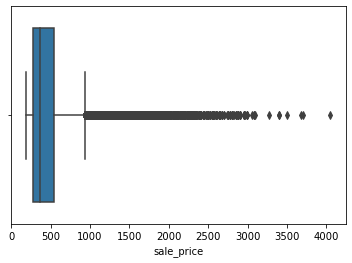

In [32]:
sns.boxplot(x = "sale_price", data= df);

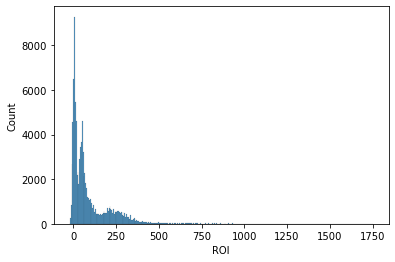

In [33]:
ROI_dist = sns.histplot(df.ROI)

Akin to the sale price the ROI of the sneakers also has numerous outliers which will be ignored for this report. 

#### Mean sale price per brand

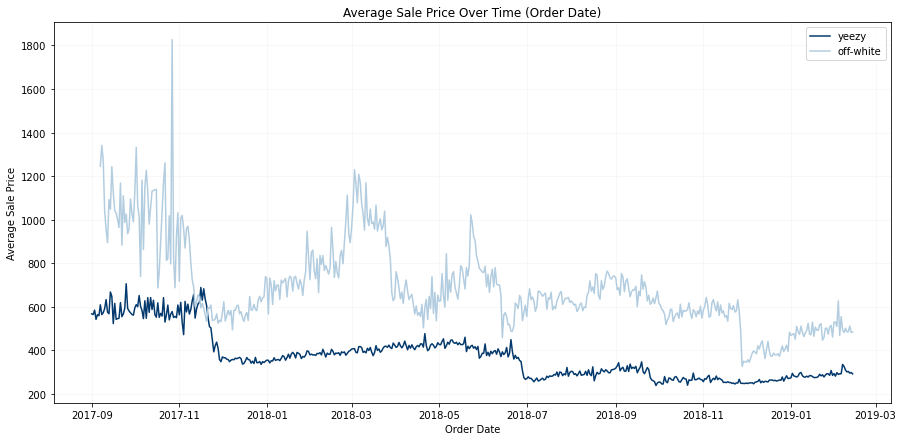

In [34]:
yeezy = df[df.brand == 'yeezy'].copy()
offwhite = df[df.brand == 'off-white'].copy()

mean_sale = df.groupby(['order_date', 'brand']).agg({'sale_price_com': 'mean'})
mean_sale = mean_sale.reset_index()

fig, ax = plt.subplots(figsize = (15,7))
fig = sns.lineplot(x="order_date", y="sale_price_com", hue="brand", palette = ['#03396c', '#b3cde0'], data=mean_sale)
plt.xlabel('Order Date')
plt.ylabel('Average Sale Price')
plt.title('Average Sale Price Over Time (Order Date)')
fig.legend_.set_title(None)
plt.grid(True, alpha = 0.1)

Analysing the average sale price of each brand across the time period it is clear that Yeezys sold at a lower price compared to the Off-Whites within the data. Furthermore, there is a downward trend for both brands indicating that there may be less hype than in the past for sneaker resales. This finding may represent a reduction in ROI for those sneakers that have been on the market for a longer time.

#### Average ROI per brand after number of days

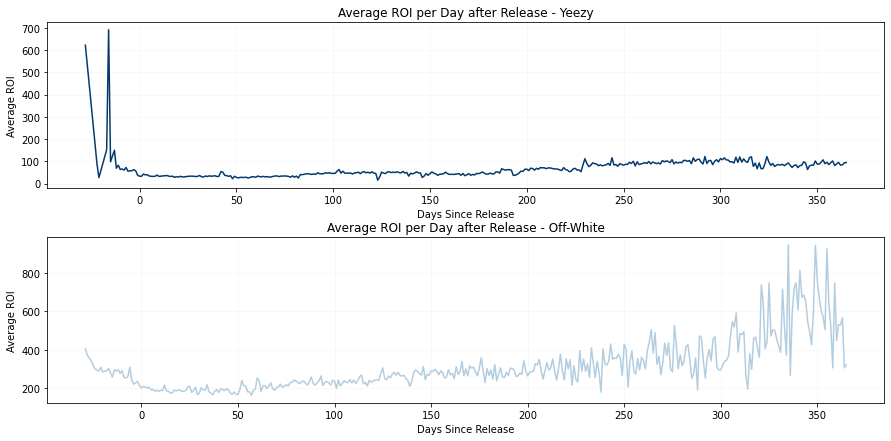

In [89]:
yeezy['less_1year'] = np.where(yeezy['day_diff'] <= 365 , 1, 0)
yeezy_ROI = yeezy[yeezy.less_1year == 1]
yeezy_ROI = yeezy_ROI[yeezy_ROI['day_diff'] > -30]

offwhite['less_1year'] = np.where(offwhite['day_diff'] <= 365 , 1, 0)
offwhite_ROI = offwhite[offwhite.less_1year == 1]
offwhite_ROI = offwhite_ROI[offwhite_ROI['day_diff'] > -30]

ROI_days_yeezy = yeezy_ROI.groupby('day_diff').agg({'ROI': 'mean'})
ROI_days_yeezy = ROI_days_yeezy.reset_index()
ROI_days_ow = offwhite_ROI.groupby('day_diff').agg({'ROI': 'mean'})
ROI_days_ow = ROI_days_ow.reset_index()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7))
fig.subplots_adjust(hspace=0.3)

sns.lineplot(x='day_diff', y='ROI', color = '#03396c', data = ROI_days_yeezy, ax=ax1)
ax1.set_xlabel('Days Since Release')
ax1.set_ylabel('Average ROI')
ax1.set_title('Average ROI per Day after Release - Yeezy')
ax1.grid(True, alpha = 0.1)

sns.lineplot(x='day_diff', y='ROI', color = '#b3cde0', data = ROI_days_ow, ax=ax2)
ax2.set_xlabel('Days Since Release')
ax2.set_ylabel('Average ROI')
ax2.set_title('Average ROI per Day after Release - Off-White')
ax2.grid(True, alpha = 0.1)

plt.show();

Concentrating specifically on the ROI, and measuring against the days since release, there is a joint finding amongst both brands that ROI is high before the release date of the shoes. This may be due pre-orders leading to inflated prices being charged by resellers to exploit early hype. Following release however both brands follow differing trends. The ROI on Yeezys remains relatively stable. However, for the Off-Whites there is an increase in ROI when reaching almost a year since release.

It is important to note that these graphs only reveal the trends up to one year. These provide information on short term price trends and as shown in the previous diagram for Off-Whites in particular, a rise in sale price to March 2018 is followed by an overall downward trend.

#### Average ROI per style

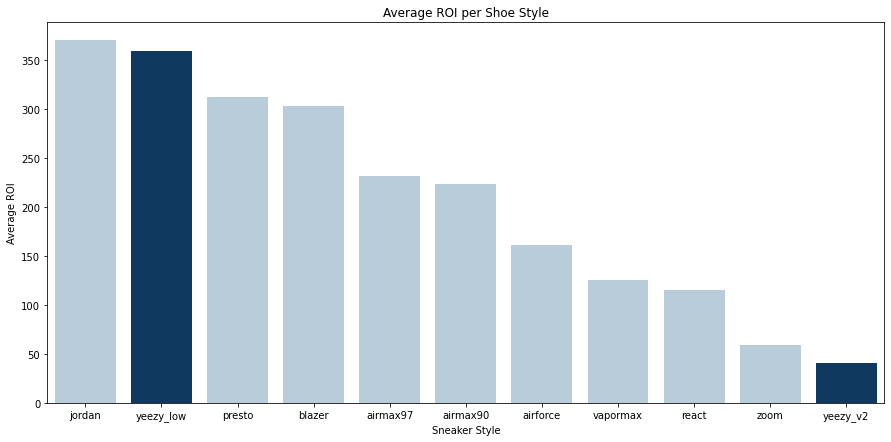

In [36]:
grp_style = df.groupby(['design']).agg({'ROI': 'mean'})
grp_style = grp_style.reset_index().sort_values(by='ROI', ascending = False)

plt.figure(figsize = (15,7))
fig = sns.barplot(x= 'design', y = 'ROI', data = grp_style,
                  palette = ['#b3cde0', '#03396c', '#b3cde0',
                             '#b3cde0', '#b3cde0', '#b3cde0',
                             '#b3cde0', '#b3cde0', '#b3cde0',
                             '#b3cde0', '#03396c'])

plt.xlabel('Sneaker Style')
plt.ylabel('Average ROI')
plt.title('Average ROI per Shoe Style')
plt.show()

As revealed, the higher average ROI's per shoe style are largely dominated by the Off-White sneakers. Although, the Yeezy Low silhouette does have the second highest ROI. The Yeezy Lows are the older version of the shoe compared to the v2 and therefore, may have been more highly coveted as an early release. In contrast, the Yeezy v2 has the lowest average ROI.

#### Shoe Size Counts

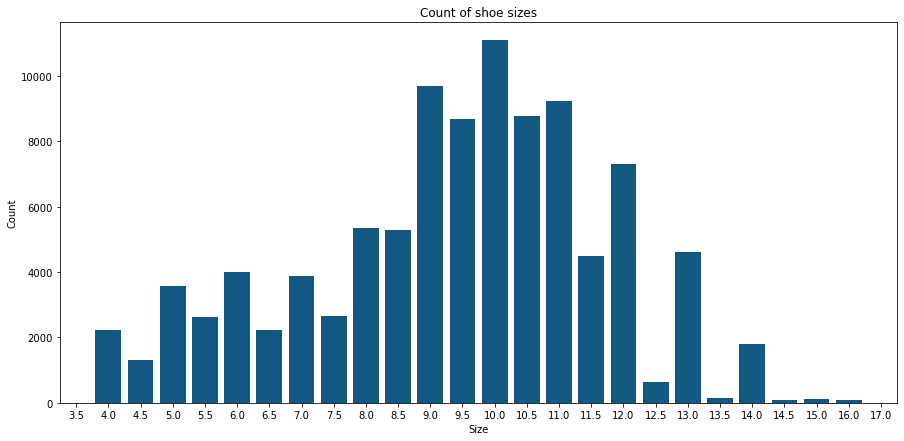

In [37]:
sizes = df.shoe_size.value_counts().to_frame()
sizes = sizes.reset_index().sort_values(by = 'index')
sizes.columns = ['size', 'count']

plt.figure(figsize = (15,7))
sns.barplot(x= 'size', y = 'count', color = '#005b96', data = sizes)
plt.xlabel('Size')
plt.ylabel('Count')
plt.title('Count of shoe sizes')

plt.show()

The distribution of shoe sizes within the data seems as expected with the majority of shoes sold being between sizes 8 and 12. There are very few sneakers sold at the extreme ends of the distribution.

#### Number of Sales per Week

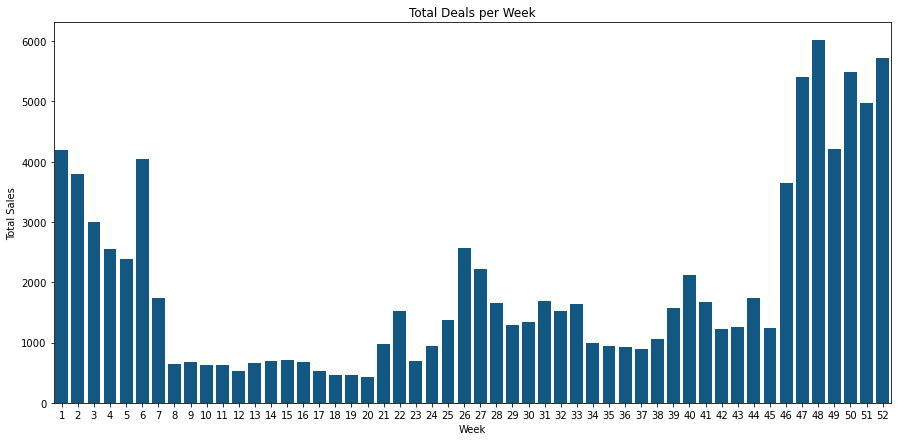

In [38]:
grouped_week = df.groupby('week').agg({'order_date':'count'})
grouped_week = grouped_week.reset_index()

plt.figure(figsize = (15,7))
fig = sns.barplot(x= 'week', y = 'order_date', data = grouped_week, color = '#005b96', alpha = 1)

plt.xlabel('Week')
plt.ylabel('Total Sales')
plt.title('Total Deals per Week')
plt.show()

#### Number of Sales per Month

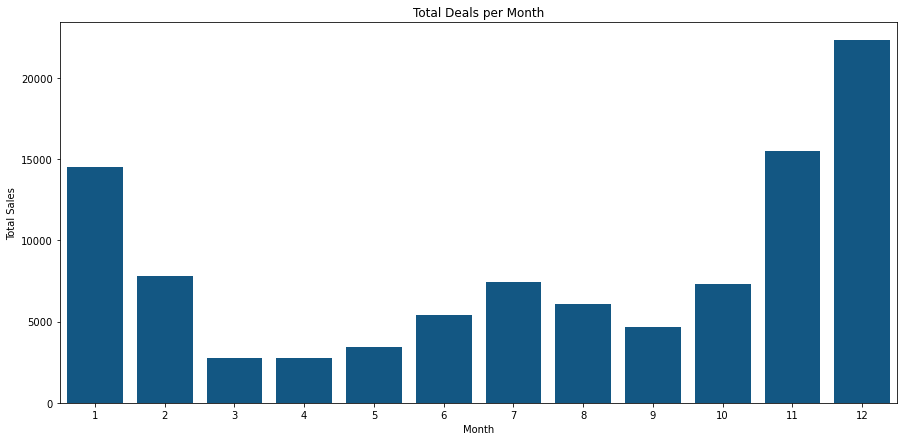

In [39]:
grouped_week = df.groupby('month').agg({'order_date':'count'})
grouped_week = grouped_week.reset_index()

plt.figure(figsize = (15,7))
fig = sns.barplot(x= 'month', y = 'order_date', data = grouped_week, color = '#005b96', alpha = 1)

plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Total Deals per Month')
plt.show()

The two graphs above highlighting the temporal aspect of sneaker sales displays some seasonality in the number of transactions. Both figures show an increase in deals towards the end of the year corresponding with the yearly festive shopping. Furthermore, there is also a slight increase in sales in the middle of the year towards the summer months which may be a result of consumers wanting to wear stylish shoes outdoors in the better weather. This indicates that resellers may look to charge higher prices when they believe that the demand from potential buyers is at its highest.

#### US States

In [40]:
state_codes = {
    'district of columbia' : 'DC','mississippi': 'MS', 'oklahoma': 'OK', 
    'delaware': 'DE', 'minnesota': 'MN', 'illinois': 'IL', 'arkansas': 'AR', 
    'new mexico': 'NM', 'indiana': 'IN', 'maryland': 'MD', 'louisiana': 'LA', 
    'idaho': 'ID', 'wyoming': 'WY', 'tennessee': 'TN', 'arizona': 'AZ', 
    'iowa': 'IA', 'michigan': 'MI', 'kansas': 'KS', 'utah': 'UT', 
    'virginia': 'VA', 'oregon': 'OR', 'connecticut': 'CT', 'montana': 'MT', 
    'california': 'CA', 'massachusetts': 'MA', 'west virginia': 'WV', 
    'south carolina': 'SC', 'new hampshire': 'NH', 'wisconsin': 'WI',
    'vermont': 'VT', 'georgia': 'GA', 'north dakota': 'ND', 
    'pennsylvania': 'PA', 'florida': 'FL', 'alaska': 'AK', 'kentucky': 'KY', 
    'hawaii': 'HI', 'nebraska': 'NE', 'missouri': 'MO', 'ohio': 'OH', 
    'alabama': 'AL', 'rhode island': 'RI', 'south dakota': 'SD', 
    'colorado': 'CO', 'new jersey': 'NJ', 'washington': 'WA', 
    'north carolina': 'NC', 'new york': 'NY', 'texas': 'TX', 
    'nevada': 'NV', 'maine': 'ME'}

df['state_code'] = df['buyer_region'].apply(lambda x : state_codes[x])

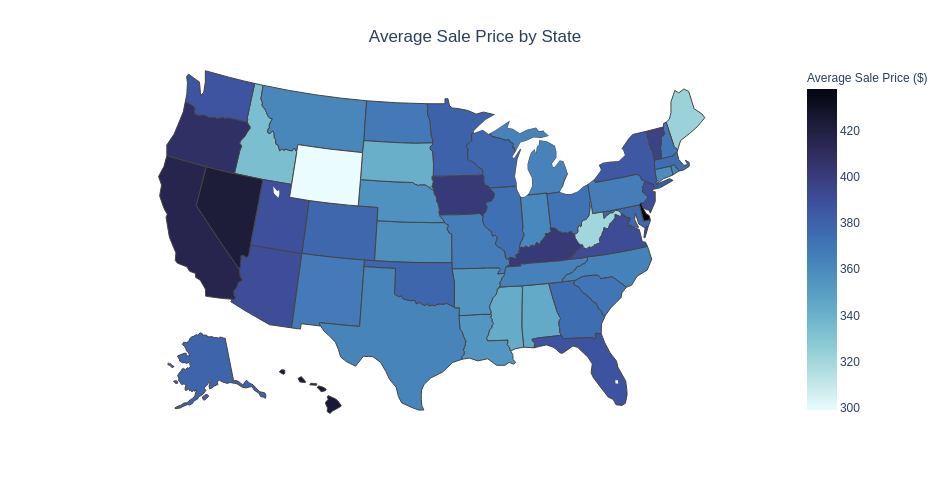

In [41]:
df_states = df.groupby('state_code').agg({'sale_price_com':'mean'})
df_states = df_states.reset_index()

fig = px.choropleth(df_states,
                    locations='state_code',
                    color='sale_price_com',
                    color_continuous_scale='ice_r',
                    hover_name='state_code',
                    locationmode='USA-states',
                    labels={'sale_price_com':'Average Sale Price ($)'},
                    scope='usa')

fig.update_layout(
    title={'text':'Average Sale Price by State',
           'xanchor':'center',
           'yanchor':'top',
           'x':0.5})

fig.show(renderer = 'png', height = 500, width = 950)

A visual plot of the average sale price by buyer region communicates clearly the higher prices being spent on average on the west coast of America. Oregon, the home of the Nike headquarters also has a high average sale price. This information can be helpful to resellers if they are able to determine which locations have a higher propensity to spend so they can efficiently extract higher profits.

## 5. ML Models

In this section, models to predict the ROI for each sneaker are run. The models consist of both linear and tree-based models with ensemble methods at the end. To evaluate the performance of each model the $R^2$ of each model will be outputted after cross validation. The mean squared error and root mean squared error of each model will further be outputted for the best model after evaluating it on the test set.

In [42]:
models = df.copy()

In [43]:
# dropping columns that are not relevant for models
models = models.drop(columns = ['order_date', 'brand', 'sneaker_name', 'sale_price', 'retail_price', 'release_date', 'shoe_size', 'buyer_region',
                                     'sale_price_com', 'week', 'state_code'])

# create dummy variables for each of the categorical variables in the dataset
models = pd.get_dummies(models, columns = ['design', 'month', 'region'], drop_first=True)

#### Correlation

To test for high correlation amongst the variables the month columns were removed to avoid crowding the figure.

In [44]:
filter_col = [col for col in models if col.startswith('month')]
corr_data = models.drop(filter_col, axis=1).copy()

<AxesSubplot:>

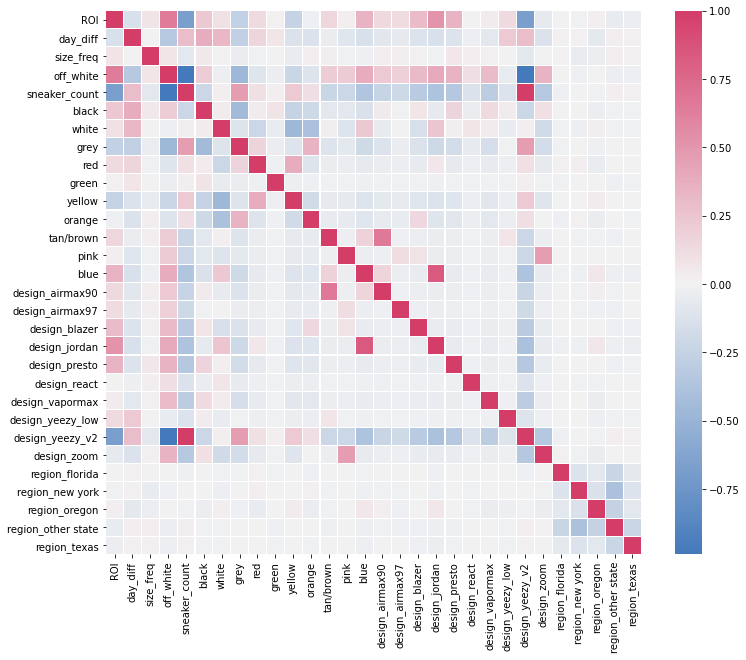

In [45]:
corrmat = corr_data.corr()
f, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(250, 0, as_cmap = True)
sns.heatmap(corrmat, ax=ax, cmap=cmap, linewidths=0.1)

In [46]:
models = models.drop(columns = ['sneaker_count', 'off_white'])

The correlation matrix indicates that there is a high correlation between the variables off_white and yeezy_v2. Furthermore, sneaker_count is highly correlated with yeezy_2 as well. These two variables will be dropped.

#### Train Test Split

In [47]:
y = models.ROI
X = models.drop('ROI', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 88)

#### Scaling

To improve model performance feature scaling using standardization was undertaken as the numerical features consisted of different scales. Using standard scaler ensures each variable has a mean of 0 and unit variance. As standardization is less affected by outliers compared to other scaling methods such as min-max scaling it was preferred.

In [48]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [50]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 5.1 Linear Regression

In [51]:
start = time.time()
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

print("Train score:", lin_reg.score(X_train_scaled, y_train))
print("Cross-validated score:", cross_val_score(lin_reg, X_train_scaled, y_train, cv = 5).mean())
stop = time.time()
print('Run time: %.2f seconds' % (stop-start))

Train score: 0.7844547157222901
Cross-validated score: 0.7840878147168603
Run time: 0.63 seconds


### 5.2 Elastic Net

Elastic Net is a regularized regression method combining both the regularization terms of the Lasso and Ridge regressions. To identify the best model, a grid search to hypertune the parameters for alpha (constant that multiplies the penalty terms) and the L1 ratio (mixing parameter) was undertaken. An L1 ratio of 0 is an L2 penalty and 1 is an L1 penalty.

In [63]:
start = time.time()
elastic_net = ElasticNet(random_state = 88, max_iter = 50000)
params_net = {'alpha': [0.01, 0.05, 0.5, 1],
              'l1_ratio': np.arange(0.1, 1.00, 0.1)}

gs_elastic_net = GridSearchCV(elastic_net, params_net, cv = 5, 
                        verbose = 1 , n_jobs = -1)

gs_elastic_net.fit(X_train_scaled, y_train)

print("Best parameters:", gs_elastic_net.best_params_)
print()
print("Train score:", gs_elastic_net.score(X_train_scaled, y_train))
print("Cross-validated score:", gs_elastic_net.best_score_)
stop = time.time()
print('Run time: %.2f seconds' % (stop-start))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'alpha': 0.01, 'l1_ratio': 0.9}

Train score: 0.7844475455223767
Cross-validated score: 0.78408102546524
Run time: 19.13 seconds


### 5.3 Linear Support Vector Machine Regressor

The hyperparameters that were tuned for the SVM were C (the regularization parameter) and epsilon (epsilon parameter in the epsilon-insensitive loss function).

In [65]:
start = time.time()
svm_model = LinearSVR(random_state = 88, tol = 0.01, max_iter = 50000)
params_svm = {'C': np.arange(1.00, 4.00, 0.5),
             'epsilon': np.arange(0.0, 1, 0.1)}

gs_svm = GridSearchCV(svm_model, params_svm, cv = 5, 
                       verbose = 1, n_jobs = -1)

gs_svm.fit(X_train_scaled, y_train)

print("Best parameters:", gs_svm.best_params_)
print()
print("Train score:", gs_svm.score(X_train_scaled, y_train))
print("Cross-validated score:", gs_svm.best_score_)
stop = time.time()
print('Run time: %.2f seconds' % (stop-start))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'C': 3.5, 'epsilon': 0.6000000000000001}

Train score: 0.7437165874059006
Cross-validated score: 0.7422975659146976
Run time: 78.64 seconds


### 5.4 Decision Tree

Moving on to the tree-based models the hyperparameters tuned for the decision tree were the max depth of the tree, the minimum samples required to split a node, and the minimum samples required at each leaf node

In [66]:
start = time.time()
tree_model = DecisionTreeRegressor(random_state = 88)
params_tree = {'max_depth': np.arange(10, 50, 5),
                  'min_samples_split' : np.arange(5, 35, 5),
                  'min_samples_leaf': np.arange(2, 15, 5)}

gs_tree = GridSearchCV(tree_model, params_tree, cv = 5,
                       verbose = 1, n_jobs = -1)

gs_tree.fit(X_train_scaled, y_train)

print("Best parameters:", gs_tree.best_params_)
print()
print("Train score:", gs_tree.score(X_train_scaled, y_train))
print("Cross-validated score:", gs_tree.best_score_)
stop = time.time()
print('Run time: %.2f seconds' % (stop-start))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'max_depth': 40, 'min_samples_leaf': 2, 'min_samples_split': 10}

Train score: 0.985030020798218
Cross-validated score: 0.9623880662868386
Run time: 70.35 seconds


### 5.5 Random Forest

The hyperparameters tuned for the random forest were the number of trees in the forest, the max depth of the tree, and the minimum samples required to split a node.

In [67]:
start = time.time()
forest_model = RandomForestRegressor(random_state = 88)
params_forest = {'n_estimators' : [50, 100, 200],
                  'max_depth':[10,25,50],
                  'min_samples_split' : [2,5,10]}

gs_forest = GridSearchCV(forest_model, params_forest, cv=5, n_jobs=-1, verbose=1)
gs_forest.fit(X_train_scaled, y_train)

print("Best parameters:", gs_forest.best_params_)
print()
print("Train score:", gs_forest.score(X_train_scaled, y_train))
print("Cross-validated score:", gs_forest.best_score_)
stop = time.time()
print('Run time: %.2f seconds' % (stop-start))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'max_depth': 50, 'min_samples_split': 5, 'n_estimators': 200}

Train score: 0.9895066337755135
Cross-validated score: 0.9707497366119735
Run time: 973.93 seconds


### 5.6 XGboost

The XGboost ensemble method that uses gradient boosting did not get hypertuned as the run time would have been lengthy. Furthermore, as the model score was already very high the trade-off from tuning was not deemed necessary.

In [69]:
start = time.time()
boost_model = xgb.XGBRegressor(random_state=88)
boost_model.fit(X_train_scaled, y_train)

print("Train score:", boost_model.score(X_train_scaled, y_train))
print("Cross-validated score:", cross_val_score(boost_model, X_train_scaled, y_train, cv = 5).mean())
stop = time.time()
print('Run time: %.2f seconds' % (stop-start))

Train score: 0.9801400736543249
Cross-validated score: 0.9695501913856696
Run time: 497.82 seconds


### 5.7 Voting Regressor

The voting regressor is another ensemble meta-estimator and the regressors used in this case are the linear regression, the best parameter random forest and the XGboost.

In [72]:
start = time.time()
# Voting Regressor using linear regression, xgboost and random forest
voting_reg = VotingRegressor([('lin', lin_reg), ('xgb', boost_model),
                              ('forest', RandomForestRegressor(max_depth = 50,
                                                               min_samples_split = 5,
                                                               n_estimators = 200,
                                                               random_state = 88))])

voting_reg.fit(X_train_scaled, y_train)

print("Train score:", voting_reg.score(X_train_scaled, y_train))
print("Cross-validated score:", cross_val_score(voting_reg, X_train_scaled, y_train, cv = 5).mean())
stop = time.time()
print('Run time: %.2f seconds' % (stop-start))

Train score: 0.9610536191043261
Cross-validated score: 0.9501013841275288
Run time: 729.13 seconds


#### Best model

The random forest boasted the highest cross validation score so the model with the tuned hyperparameters was selected to be run and evaluated on the test set.

In [73]:
# retrain random forest on full training data
start = time.time()
rfm_model = RandomForestRegressor(n_estimators = 200, max_depth = 50, min_samples_split = 5, random_state = 88)
final_model = rfm_model.fit(X_train_scaled, y_train)
stop = time.time()
print('Run time: %.2f seconds' % (stop-start))

Run time: 45.22 seconds


In [75]:
# test set performance
pred_test_forest = final_model.predict(X_test_scaled)

mse_forest = mean_squared_error(y_test, pred_test_forest)
print('R2 Score: %.4f' % r2_score(y_test, pred_test_forest))
print('MSE: %.2f' % mse_forest)
print('RMSE: %.2f' % (mse_forest**(1/2.0)))

R2 Score: 0.9739
MSE: 449.50
RMSE: 21.20


The performance of the final random forest model on the test set was very high. Additionally, the mean squared error and root mean squared error are outlined and can be utilised to compare against other models that are developed.

## 6. Conclusion

This report focused on evaluating the predictive capability of different machine learning models to predict the resale price premium / ROI for sneakers listed on StockX. With models such as random forest and XGboost reaching very high scores of accuracy these models present resellers the opportunity to identify what ROI they can expect on certain sneakers and selectively choose those that offer greater potential for higher profits.

#### Limitations

Two limitations of this work are that the most recently sold sneakers were observed in 2019. This may mean the data is less applicable in the current market. Furthermore, only concentrating on Yeezys and Off-Whites again reduces the generalisability of the results. Further research may seek to expand on the dataset to other sneakers whilst also exploring more machine learning models and hyperparameter tuning.

# References

Kernan, J., O. Chen, K. Zuber and J. Orr. 2020. Sneakers as an Alternative Asset Class, Part II. *Cowen* URL https://www.cowen.com/insights/sneakers-as-an-alternative-asset-class-part-ii/